# VR EEG Emotion Classification

Workflow: **load → clean → EDA → windowing/feature extraction → train/test → models → evaluation**.

# **1. Importing Library and Dataset**

In [296]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import welch
from sklearn.base import clone
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import label_binarize, RobustScaler
from sklearn.metrics import (
    classification_report, accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,
 )
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Flatten, Dense, Dropout, Input,
    SimpleRNN, LSTM, Bidirectional,
    Conv1D, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention, Add,
    Conv2D, DepthwiseConv2D, SeparableConv2D, AveragePooling2D, BatchNormalization, Activation,
    Reshape,
 )
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [297]:
csvfile = pd.read_csv('dataset.csv')

# **2. Exploratory Data Analysis (EDA)**

## 2.1 Data Cleaning and Missing/Error Values

### 2.1.1 Understanding the dataset

Understanding the dimensions and finding out errors.

***Dataset***

In [298]:
csvfile

,Participant,Classification,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
0,p1,Calm,848.1685,838.49817,861.8681,865.4945
1,p1,Calm,840.5128,851.79486,847.3626,844.94507
2,p1,Calm,819.9634,823.18680,815.5311,833.2601
3,p1,Calm,838.0952,842.12450,848.97437,850.58606
4,p1,Calm,849.7802,849.78020,829.6337,838.49817
...,...,...,...,...,...,...
19003,p9,Bored,865.89746,836.48350,858.24176,877.1795
19004,p9,Bored,874.7619,857.43590,831.2454,896.9231
19005,p9,Bored,906.99634,897.72894,925.5311,939.6337
19006,p9,Bored,795.38464,823.99270,979.12085,731.7216


***Information***

In [299]:
csvfile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19008 entries, 0 to 19007
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Participant     19008 non-null  object 
 1   Classification  19008 non-null  object 
 2   RAW_TP9         19008 non-null  object 
 3   RAW_AF7         19008 non-null  float64
 4   RAW_AF8         19008 non-null  object 
 5   RAW_TP10        19008 non-null  object 
dtypes: float64(1), object(5)
memory usage: 891.1+ KB


***Determining Numerical Features***

In [300]:
numerical_data = csvfile.select_dtypes(include='number')

numerical_features = numerical_data.columns.tolist()

print(f'There are {len(numerical_features)} numerical features:', '\n')
print(numerical_features)

There are 1 numerical features: 

['RAW_AF7']


Only one numerical features is not correct

***Checking `null` values***

In [301]:
csvfile.isnull().sum()

Participant       0
Classification    0
RAW_TP9           0
RAW_AF7           0
RAW_AF8           0
RAW_TP10          0
dtype: int64

***Checking `#NUM!` values***

In [302]:
(csvfile == "#NUM!").sum()

Participant        0
Classification     0
RAW_TP9           13
RAW_AF7            0
RAW_AF8           10
RAW_TP10          19
dtype: int64

RAW_TP9, RAW_AF8 AND RAW_TP10 Contain multiple #NUM! Values

### 2.1.2 Fixing the error in the dataset

***Drop `#NUM!` rows***

In [303]:
csvfile = csvfile.replace('#NUM!', np.nan)
csvfile = csvfile.dropna()

csvfile = csvfile.apply(pd.to_numeric, errors='ignore')

***Updated Dimensions***

In [304]:
print('Updated Dimensions - \n')
shape = csvfile.shape
print("Rows:", shape[0])
print("Cols:", shape[1])

Updated Dimensions - 

Rows: 18988
Cols: 6


### 2.1.3 Dataset Analysis

***Updated Numerical Features***

In [305]:
numerical_data = csvfile.select_dtypes(include='number')

numerical_features = numerical_data.columns.tolist()

print(f'There are {len(numerical_features)} numerical features:', '\n')
print(numerical_features)

There are 4 numerical features: 

['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']


***Categorical Features***

In [306]:
categorical_data=csvfile.select_dtypes(include= 'object')

categorical_features=categorical_data.columns.tolist()

print(f'There are {len(categorical_features)} categorical features:', '\n')
print(categorical_features)

There are 2 categorical features: 

['Participant', 'Classification']


***Transposed Stats of Numerical Features***

In [307]:
numerical_data.describe().T

,count,mean,std,min,25%,50%,75%,max
RAW_TP9,18988.0,841.563838,95.301082,0.000000,822.38100,844.94507,864.285700,1650.0
RAW_AF7,18988.0,851.963443,73.466107,8.058608,836.08057,850.98900,865.091550,1650.0
RAW_AF8,18988.0,850.781942,170.899455,0.000000,829.63370,850.18317,869.523800,1650.0
RAW_TP10,18988.0,840.564002,107.160816,0.402930,821.17220,844.94507,864.789382,1650.0


***Transposed Stats of Categorical Features***

In [308]:
categorical_data.describe().T

,count,unique,top,freq
Participant,18988,31,p7,624
Classification,18988,4,Calm,4786


***Unique Values in Numerical Features***

In [309]:
numerical_data.nunique()

RAW_TP9     1419
RAW_AF7     1264
RAW_AF8     2058
RAW_TP10    1533
dtype: int64

***Unique Values in Categorical Features***

In [310]:
unique_counts=categorical_data.nunique()
print(unique_counts)

Participant       31
Classification     4
dtype: int64


## 2.2 Class Distribution / Imbalance

### 2.2.1 Variance

In [311]:
numerical_data = csvfile.select_dtypes(include='number')
numerical_features=numerical_data.columns.tolist()
numerical_data.var()

RAW_TP9      9082.296237
RAW_AF7      5397.268907
RAW_AF8     29206.623845
RAW_TP10    11483.440566
dtype: float64

**RAW_AF8  - Noisiest i.e. Most Active <br>
RAW_AF7  - Quietist i.e. Most Stable <br>
RAW_TP9  - Moderate Activity <br>
RAW_TP10 - Moderate Activity**

### 2.2.2 Distribution of Emotions

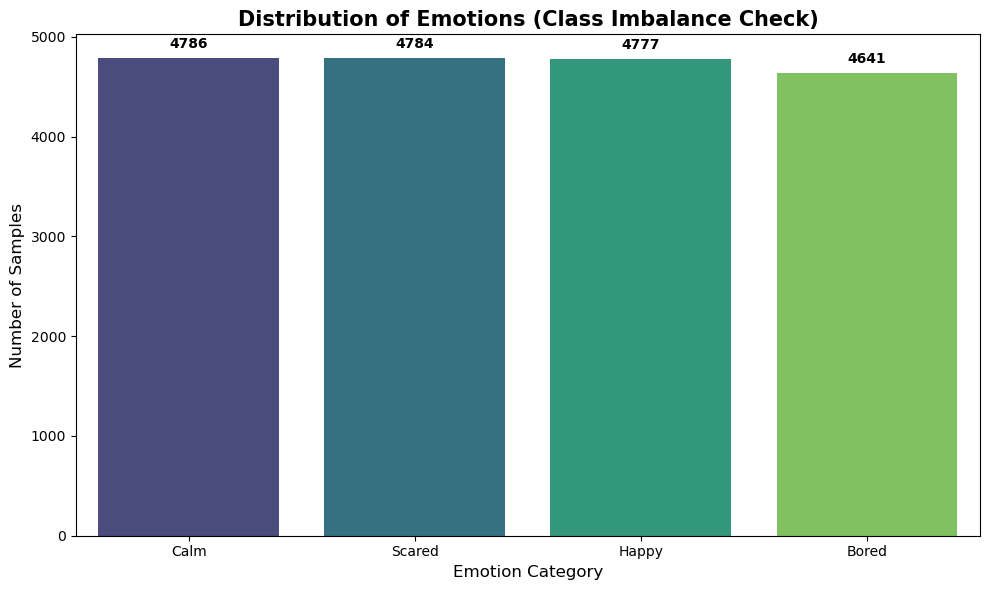

In [312]:
plt.figure(figsize=(10, 6))

sns.countplot(
    x='Classification', 
    data=csvfile, 
    hue='Classification', 
    palette='viridis', 
    legend=False
)

# Title and labels
plt.title('Distribution of Emotions (Class Imbalance Check)', fontsize=15, fontweight='bold')
plt.xlabel('Emotion Category', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)

# Counts on top of the bars
counts = csvfile['Classification'].value_counts()

for i, label in enumerate(counts.index):
    count = counts[label]
    plt.text(i, count + 100, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

Emotions are evenly distributed

### 2.2.3 Skew

Using skew, plotting histogram and density plot to find out skewness to determine which scaler to use

***Skew***

In [313]:
numerical_data.skew()

RAW_TP9    -0.608259
RAW_AF7     0.537695
RAW_AF8    -0.204649
RAW_TP10   -0.420753
dtype: float64

***Histogram for Numerical Features***

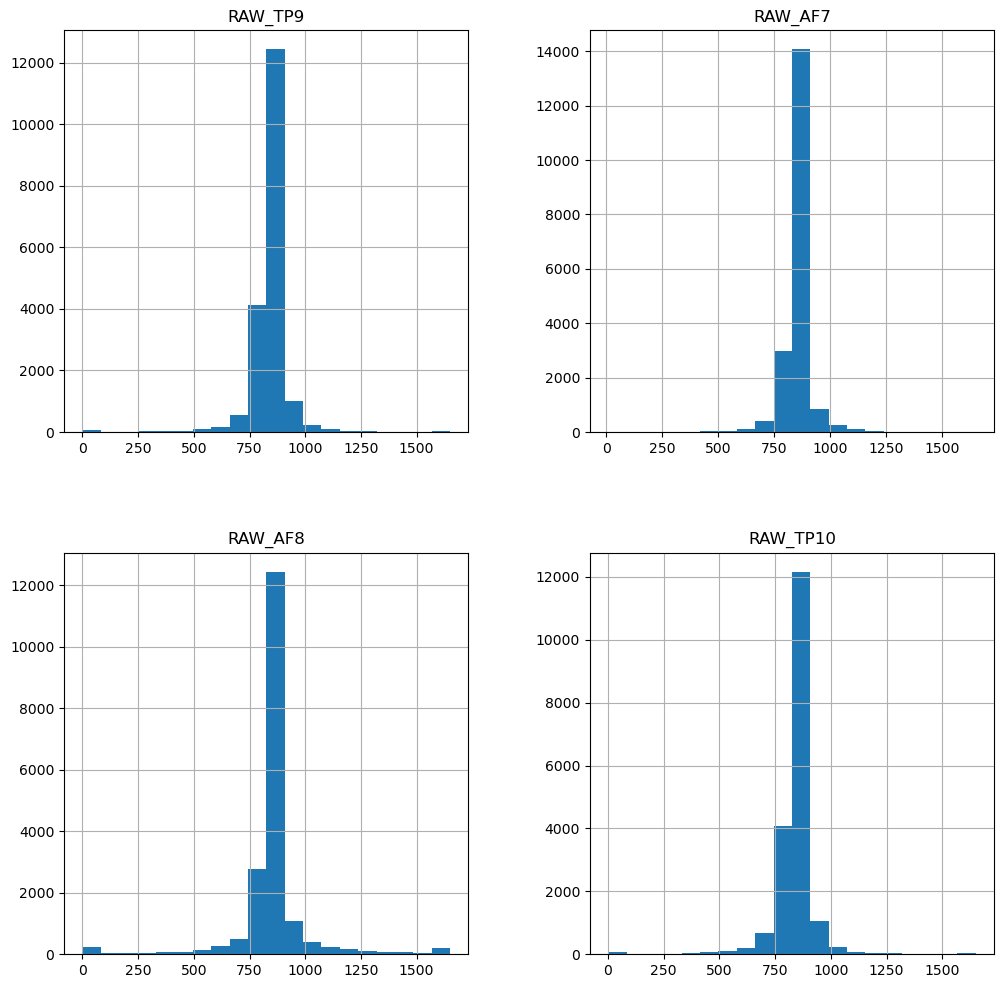

In [314]:
numerical_data.hist(figsize=(12,12),bins=20)
plt.show()

***Density Plot for Numerical Features***

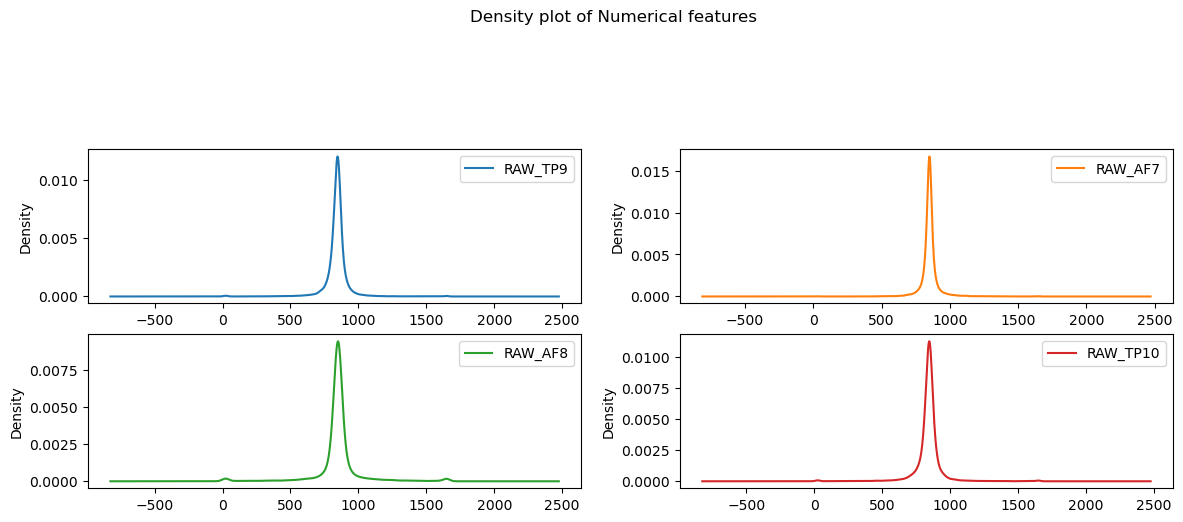

In [315]:
numerical_data.plot(kind='density',figsize=(14,14),subplots=True,layout=(6,2),title="Density plot of Numerical features",sharex=False)
plt.show()

***Verdict***

We should use Robust Scaler

## 2.3 Feature Correlation

***Correlation Matrix***

In [316]:
correlation_matrix = numerical_data.corr()
correlation_matrix

,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
RAW_TP9,1.000000,0.119619,0.011483,0.480414
RAW_AF7,0.119619,1.000000,0.123385,0.095268
RAW_AF8,0.011483,0.123385,1.000000,0.001759
RAW_TP10,0.480414,0.095268,0.001759,1.000000


***Heatmap for Correlation Matrix***

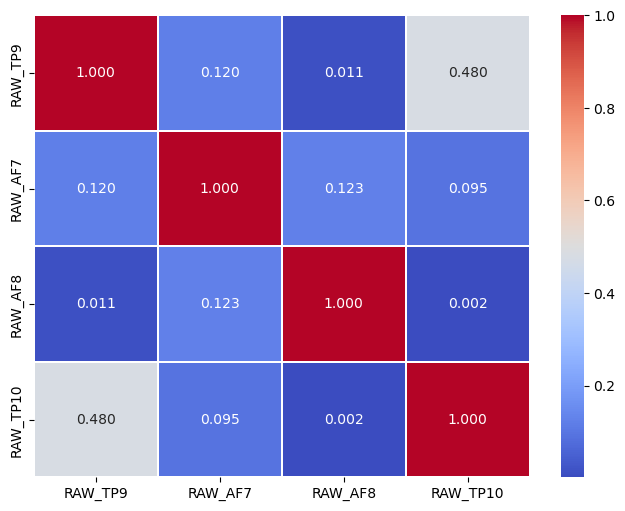

In [317]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.3)
plt.show()

No linear relationship between the EEG Signals

# **3. Modeling & Feature Extraction**

## 3.1 Label encoding + feature/target definition

### 3.1.1 Label Encoding
Label Encoding the Classification and Participant column to numbers

In [318]:
csvfile['Classification'] = pd.factorize(csvfile['Classification'])[0]
csvfile['Participant'] = pd.factorize(csvfile['Participant'])[0]

In [319]:
csvfile

,Participant,Classification,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
0,0,0,848.16850,838.49817,861.86810,865.49450
1,0,0,840.51280,851.79486,847.36260,844.94507
2,0,0,819.96340,823.18680,815.53110,833.26010
3,0,0,838.09520,842.12450,848.97437,850.58606
4,0,0,849.78020,849.78020,829.63370,838.49817
...,...,...,...,...,...,...
19003,30,3,865.89746,836.48350,858.24176,877.17950
19004,30,3,874.76190,857.43590,831.24540,896.92310
19005,30,3,906.99634,897.72894,925.53110,939.63370
19006,30,3,795.38464,823.99270,979.12085,731.72160


### 3.1.2 Input and Output Split
Making the EEG Signals Input and Participant and Column be the Output

In [320]:
# X = Input features, Y = Output label
# Keep Participant separately (Windowing later)

feature_cols = csvfile.drop(columns=['Classification', 'Participant']).columns.tolist()

x = csvfile[feature_cols]
y = csvfile['Classification']

print('Feature columns used for ML:', feature_cols)

Feature columns used for ML: ['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']


In [321]:
print('Input')
print()
print(x)

Input

         RAW_TP9    RAW_AF7    RAW_AF8   RAW_TP10
0      848.16850  838.49817  861.86810  865.49450
1      840.51280  851.79486  847.36260  844.94507
2      819.96340  823.18680  815.53110  833.26010
3      838.09520  842.12450  848.97437  850.58606
4      849.78020  849.78020  829.63370  838.49817
...          ...        ...        ...        ...
19003  865.89746  836.48350  858.24176  877.17950
19004  874.76190  857.43590  831.24540  896.92310
19005  906.99634  897.72894  925.53110  939.63370
19006  795.38464  823.99270  979.12085  731.72160
19007  801.42860  846.55676  857.83880  784.10254

[18988 rows x 4 columns]


In [322]:
print('Output')
print()
print(y)

Output

0        0
1        0
2        0
3        0
4        0
        ..
19003    3
19004    3
19005    3
19006    3
19007    3
Name: Classification, Length: 18988, dtype: int64


## 3.2 Windowing + Welch bandpower features

This section creates window-level features from raw EEG channels (TP9, AF7, AF8, TP10):

- **Frequency bands**: delta (1–4 Hz), theta (4–8 Hz), alpha (8–13 Hz), beta (13–30 Hz), gamma (30–45 Hz).
- **Welch PSD**: estimates power spectral density for each sliding window, then integrates power in each band.
- **Participant-wise normalization (optional)**: normalizes each participant’s raw channels to reduce subject-specific offsets.
- **Sliding windows**: window length `win=64` samples, step `step=16` samples (overlap).
- **Output features**: 4 channels × 5 bands = **20 bandpower features** per window (log-transformed).

Note: windows are generated **within each Participant×Class segment** to avoid mixed-label windows.

### 3.2.1 Windowed EEG Feature Extraction

In [323]:
eeg_cols = ['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10']

fs_hz = 256  # For frequency axis of Welch
window_samples = 64   # Multiple windows per segment (~154 rows each)
step_samples = 16
win = int(window_samples)
step = int(step_samples)

bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta' : (13, 30),
    'gamma': (30, 45),
}

def bandpower_welch(x_1d: np.ndarray, fs: int, fmin: float, fmax: float) -> float:
    nperseg = min(256, int(x_1d.shape[0]))
    if nperseg < 16:
        return 0.0
    nfft = 256
    f, pxx = welch(
        x_1d, fs=fs, nperseg=nperseg, noverlap=nperseg // 2, nfft=nfft
    )
    mask = (f >= fmin) & (f < fmax)
    if not np.any(mask):
        return 0.0
    return float(np.trapz(pxx[mask], f[mask]))

# Ensuring labels are numeric 0..K-1
if not np.issubdtype(csvfile['Classification'].dtype, np.number):
    csvfile['Classification'] = pd.factorize(csvfile['Classification'])[0]

# Windows within each Participant+Classification segment to avoid mixed-label windows
group_cols = ['Classification']
if 'Participant' in csvfile.columns:
    group_cols = ['Participant', 'Classification']

# Participant-wise normalization helps subject-independent generalization (reduces per-subject offsets)
participant_stats = None
if 'Participant' in csvfile.columns:
    stats = {}
    for pid, gpid in csvfile.groupby('Participant', sort=False):
        m = gpid[eeg_cols].to_numpy(dtype=np.float32).mean(axis=0, keepdims=True)
        s = gpid[eeg_cols].to_numpy(dtype=np.float32).std(axis=0, keepdims=True) + 1e-6
        stats[pid] = (m, s)
    participant_stats = stats

feature_rows = []
y_band = []
groups_win = []
seq_windows = []

# Diagnostics: how long are the segments?
seg_lengths = []
for _, g in csvfile.groupby(group_cols, sort=False):
    seg_lengths.append(len(g))
print('Segment length summary (rows per Participant×Class):')
print(pd.Series(seg_lengths).describe())
print('Using win=', win, 'step=', step)

for key, g in csvfile.groupby(group_cols, sort=False):
    # key is (participant, class) or (class,)
    if isinstance(key, tuple):
        participant_id = key[0] if ('Participant' in group_cols) else None
        class_id = key[-1]
    else:
        participant_id = None
        class_id = key
    eeg = g[eeg_cols].to_numpy(dtype=np.float32)
    # Normalize per participant (if available)
    if participant_id is not None and participant_stats is not None and participant_id in participant_stats:
        m, s = participant_stats[participant_id]
        eeg = (eeg - m) / s
    n = eeg.shape[0]
    if n < win:
        continue
    for start in range(0, n - win + 1, step):
        seg = eeg[start:start+win]  # (win, 4)
        if not np.isfinite(seg).all():
            continue
        # PSD bandpower features: 5 bands x 4 channels = 20 features
        feats = {}
        for ch_name in eeg_cols:
            xch = seg[:, eeg_cols.index(ch_name)]
            for bname, (fmin, fmax) in bands.items():
                bp = bandpower_welch(xch, fs_hz, fmin, fmax)
                feats[f"{ch_name}_{bname}"] = np.log10(bp + 1e-12)
        feature_rows.append(feats)
        y_band.append(int(class_id))
        if participant_id is not None:
            groups_win.append(participant_id)
        seq_windows.append(seg)
        
x_band = pd.DataFrame(feature_rows)
X_seq_all = np.stack(seq_windows, axis=0).astype(np.float32)
y_band = np.asarray(y_band, dtype=np.int32)
if len(groups_win) > 0:
    groups_win = np.asarray(groups_win)

print('Built windowed dataset:')
print('x_band:', x_band.shape, 'X_seq_all:', X_seq_all.shape, 'y_band:', y_band.shape)
print('Class counts:', pd.Series(y_band).value_counts().sort_index().to_dict())

Segment length summary (rows per Participant×Class):
count    124.000000
mean     153.129032
std        3.861353
min      125.000000
25%      154.000000
50%      154.000000
75%      155.000000
max      158.000000
dtype: float64
Using win= 64 step= 16
Built windowed dataset:
x_band: (740, 20) X_seq_all: (740, 64, 4) y_band: (740,)
Class counts: {0: 186, 1: 186, 2: 186, 3: 182}


In [324]:
# Feature engineering on windowed data (improves signal vs raw log-bandpowers)
# Builds additional features from x_band (bandpower) and X_seq_all (time-domain stats).
x_feat = x_band.copy()
eps = 1e-12

# ---- Relative bandpowers + ratios (computed in linear domain) ----
# Convert log10(bp + eps) back to approx linear bp for ratios
for ch in ['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10']:
    band_cols = [f"{ch}_{b}" for b in ['delta','theta','alpha','beta','gamma'] if f"{ch}_{b}" in x_feat.columns]
    if len(band_cols) != 5:
        continue
    bp_lin = np.stack([(10 ** x_feat[c].to_numpy(dtype=np.float64) - eps) for c in band_cols], axis=1)
    bp_lin = np.clip(bp_lin, 0.0, None)
    total = bp_lin.sum(axis=1, keepdims=True) + eps
    rel = bp_lin / total
    for i, b in enumerate(['delta','theta','alpha','beta','gamma']):
        x_feat[f"{ch}_{b}_rel"] = rel[:, i].astype(np.float32)
        x_feat[f"{ch}_{b}_logrel"] = np.log10(rel[:, i] + eps).astype(np.float32)
    # A few common ratios (log-ratio is often more stable)
    def _col(bname: str) -> np.ndarray:
        return bp_lin[:, ['delta','theta','alpha','beta','gamma'].index(bname)]
    alpha = _col('alpha'); beta = _col('beta'); theta = _col('theta'); delta = _col('delta')
    x_feat[f"{ch}_alpha_beta"] = (alpha + eps) / (beta + eps)
    x_feat[f"{ch}_theta_beta"] = (theta + eps) / (beta + eps)
    x_feat[f"{ch}_abd_ttd"] = (alpha + beta + eps) / (theta + delta + eps)
    x_feat[f"{ch}_log_alpha_beta"] = np.log10((alpha + eps) / (beta + eps))
    x_feat[f"{ch}_log_theta_beta"] = np.log10((theta + eps) / (beta + eps))
    x_feat[f"{ch}_log_abd_ttd"] = np.log10((alpha + beta + eps) / (theta + delta + eps))

# ---- Simple time-domain stats from raw window sequences ----
# X_seq_all: (n_windows, timesteps, 4) aligned with x_band rows
Xw = np.asarray(X_seq_all, dtype=np.float32)

ch_names = ['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10']
means = Xw.mean(axis=1)
stds = Xw.std(axis=1)
ptp = Xw.max(axis=1) - Xw.min(axis=1)
rms = np.sqrt(np.mean(np.square(Xw), axis=1))
absmean = np.mean(np.abs(Xw), axis=1)
for i, ch in enumerate(ch_names):
    x_feat[f"{ch}_td_mean"] = means[:, i]
    x_feat[f"{ch}_td_std"] = stds[:, i]
    x_feat[f"{ch}_td_ptp"] = ptp[:, i]
    x_feat[f"{ch}_td_rms"] = rms[:, i]
    x_feat[f"{ch}_td_absmean"] = absmean[:, i]

# ---- Asymmetry features (AF7 vs AF8) ----
# Use log-bandpowers when present (stable differences)
for b in ['delta','theta','alpha','beta','gamma']:
    c1 = f"RAW_AF7_{b}"
    c2 = f"RAW_AF8_{b}"
    if c1 in x_feat.columns and c2 in x_feat.columns:
        x_feat[f"AF7_minus_AF8_{b}"] = (x_feat[c1] - x_feat[c2]).astype(np.float32)
        x_feat[f"AF7_over_AF8_{b}"] = (10 ** x_feat[c1] + eps) / (10 ** x_feat[c2] + eps)
        x_feat[f"log_AF7_over_AF8_{b}"] = np.log10(x_feat[f"AF7_over_AF8_{b}"] + eps).astype(np.float32)

# Overwrite x_band so downstream split/scaling uses enhanced features
x_band = x_feat
print('Enhanced x_band features:', x_band.shape)
print('Example columns:', list(x_band.columns[:10]))

Enhanced x_band features: (740, 119)
Example columns: ['RAW_TP9_delta', 'RAW_TP9_theta', 'RAW_TP9_alpha', 'RAW_TP9_beta', 'RAW_TP9_gamma', 'RAW_AF7_delta', 'RAW_AF7_theta', 'RAW_AF7_alpha', 'RAW_AF7_beta', 'RAW_AF7_gamma']


# 4. Train/test split + scaling

We split window-level samples into train/test (optionally **grouped by Participant** to avoid subject leakage), then scale features.

In [325]:
# LOSO Cross-Validation (Participant-disjoint) — setup
##
# This replaces the old GroupShuffleSplit train/test split with Leave-One-Subject-Out (LOSO).
# In the next cells we will:
#  1) run LOSO CV baselines, and
#  2) pick one held-out participant fold to populate X_train/X_test for downstream cells.

idx = np.arange(len(x_band))
y_arr = np.asarray(y_band, dtype=np.int32)
groups = np.asarray(groups_win)

logo = LeaveOneGroupOut()
splits = list(logo.split(idx, y_arr, groups=groups))
unique_groups = np.unique(groups)
n_folds = len(splits)

print(f'Using LOSO (LeaveOneGroupOut): folds={n_folds}, participants={len(unique_groups)}')

Using LOSO (LeaveOneGroupOut): folds=31, participants=31


In [326]:
# Pick one LOSO fold for downstream cells
##
# The rest of the notebook expects a single train/test split (X_train/X_test etc).
# Here we choose one LOSO fold to act as that split.

_fold_to_use = int(globals().get('LOSO_FOLD', 0))

train_idx, test_idx = splits[_fold_to_use]
heldout_groups = np.unique(groups[test_idx])
heldout_pid = int(heldout_groups[0]) if heldout_groups.size else None

X_train = x_band.iloc[train_idx].reset_index(drop=True)
X_test = x_band.iloc[test_idx].reset_index(drop=True)
y_train = pd.Series(y_arr[train_idx])
y_test = pd.Series(y_arr[test_idx])

# Keep raw window sequences aligned with the same indices
# Shape: (n_windows, timesteps, n_channels=4)
X_train_seq = X_seq_all[train_idx]
X_test_seq = X_seq_all[test_idx]

print(f"Selected fold LOSO_FOLD={_fold_to_use}: held-out participant={heldout_pid}")
print('X_train:', X_train.shape, 'y_train:', y_train.shape)
print('X_test :', X_test.shape, 'y_test :', y_test.shape)
print('X_train_seq:', X_train_seq.shape, 'X_test_seq:', X_test_seq.shape)

Selected fold LOSO_FOLD=0: held-out participant=0
X_train: (716, 119) y_train: (716,)
X_test : (24, 119) y_test : (24,)
X_train_seq: (716, 64, 4) X_test_seq: (24, 64, 4)


In [327]:
# Scaling (fit on LOSO train only)
##
# Downstream classical ML cells expect X_train_scaled / X_test_scaled.

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Scaled:', X_train_scaled.shape, X_test_scaled.shape)

Scaled: (716, 119) (24, 119)


# 5. Optional diagnostics / tuning

These cells help quantify **subject leakage** and optionally run a lightweight hyperparameter search.

In [ ]:
# Diagnostic: subject-disjoint baseline (NO random split)
#
# This cell exists to sanity-check that your performance is measured without subject leakage.
if 'x_band' not in globals() or 'y_band' not in globals() or 'groups_win' not in globals():
    raise NameError('Need x_band, y_band, groups_win. Run windowing + feature-engineering first.')

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import RobustScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X = x_band.to_numpy(dtype=np.float32)
y = np.asarray(y_band, dtype=np.int32)
groups = np.asarray(groups_win)
idx = np.arange(len(y))

gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=5)
train_idx, test_idx = next(gss.split(idx, y, groups=groups))

scaler = RobustScaler()
Xtr = scaler.fit_transform(X[train_idx])
Xte = scaler.transform(X[test_idx])
ytr, yte = y[train_idx], y[test_idx]

models = {
    'LinearSVC': LinearSVC(class_weight='balanced', random_state=5, dual=False, max_iter=10000),
    'RandomForest': RandomForestClassifier(n_estimators=400, class_weight='balanced', random_state=5),
}

out = {}
for mname, m in models.items():
    m.fit(Xtr, ytr)
    pred = m.predict(Xte)
    out[mname] = float(accuracy_score(yte, pred))

print('GroupSplit (no subject leakage):', out)

GroupSplit (no subject leakage) {'LinearSVC': 0.3559322033898305, 'RandomForest': 0.3601694915254237}
RandomSplit (possible leakage) {'LinearSVC': 0.4189189189189189, 'RandomForest': 0.5630630630630631}


{'LinearSVC': 0.4189189189189189, 'RandomForest': 0.5630630630630631}

In [ ]:
# Auto-tune (HONEST): participant-disjoint holdout + GroupKFold CV
#
# This cell performs model selection WITHOUT subject leakage:
# - Holdout split: GroupShuffleSplit over Participant IDs
# - Tuning CV: GroupKFold over Participant IDs

import numpy as np
import pandas as pd

from sklearn.model_selection import GroupShuffleSplit, GroupKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.svm import LinearSVC

if 'x_band' not in globals() or 'y_band' not in globals() or 'groups_win' not in globals():
    raise NameError('Need x_band, y_band, groups_win. Run windowing + feature engineering first.')

X_df = x_band.copy()
y_arr = np.asarray(y_band, dtype=np.int32)
groups = np.asarray(groups_win)

# -------------------- Honest evaluation (GroupSplit holdout + GroupKFold tuning) --------------------
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=5)
idx = np.arange(len(y_arr))
train_idx, test_idx = next(gss.split(idx, y_arr, groups=groups))

X_train_df = X_df.iloc[train_idx].reset_index(drop=True)
y_train_arr = y_arr[train_idx]
g_train = groups[train_idx]
X_test_df = X_df.iloc[test_idx].reset_index(drop=True)
y_test_arr = y_arr[test_idx]

# Models to try (keep it fast)
candidates = []

# LinearSVC (scaled)
svc_pipe = Pipeline([
    ('scale', RobustScaler()),
    ('clf', LinearSVC(class_weight='balanced', dual=False, random_state=5, max_iter=20000)),
])
svc_params = {
    'clf__C': np.logspace(-2, 2, 15),
}
candidates.append(('LinearSVC', svc_pipe, svc_params))

# RandomForest
rf = RandomForestClassifier(class_weight='balanced', random_state=5, n_jobs=-1)
rf_params = {
    'n_estimators': [300, 600, 1000],
    'max_depth': [None, 8, 12, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.3, 0.5, 0.8],
}
candidates.append(('RandomForest', rf, rf_params))

# ExtraTrees (often better on engineered tabular features)
et = ExtraTreesClassifier(class_weight='balanced', random_state=5, n_jobs=-1)
et_params = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [None, 8, 12, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.3, 0.5, 0.8],
}
candidates.append(('ExtraTrees', et, et_params))

# HistGradientBoosting (fast, strong baseline)
hgb = HistGradientBoostingClassifier(random_state=5)
hgb_params = {
    'learning_rate': [0.03, 0.06, 0.1],
    'max_depth': [3, 5, 7, None],
    'max_leaf_nodes': [15, 31, 63],
    'min_samples_leaf': [10, 20, 40],
}
candidates.append(('HistGB', hgb, hgb_params))

cv = GroupKFold(n_splits=5)
best_honest = None
honest_results = {}

for name, model, params in candidates:
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=12,
        scoring='accuracy',
        cv=cv.split(X_train_df, y_train_arr, groups=g_train),
        random_state=5,
        n_jobs=-1,
        verbose=0,
    )
    search.fit(X_train_df, y_train_arr)
    best = search.best_estimator_
    pred = best.predict(X_test_df)
    acc = float(accuracy_score(y_test_arr, pred))
    honest_results[name] = {
        'cv_best': float(search.best_score_),
        'test_acc': acc,
        'best_params': search.best_params_,
    }
    if best_honest is None or acc > best_honest[1]:
        best_honest = (name, acc)

print('HONEST (GroupSplit holdout) results:')
for k, v in sorted(honest_results.items(), key=lambda kv: kv[1]['test_acc'], reverse=True):
    print(f"  {k:12s} test_acc={v['test_acc']:.3f}  cv_best={v['cv_best']:.3f}")
print('Best honest model:', best_honest)

HONEST (GroupSplit holdout) results:
  ExtraTrees   test_acc=0.381  cv_best=0.360
  LinearSVC    test_acc=0.377  cv_best=0.302
  RandomForest test_acc=0.364  cv_best=0.340
  HistGB       test_acc=0.318  cv_best=0.336
Best honest model: ('ExtraTrees', 0.3813559322033898)

LEAKY (RandomSplit + Participant feature) results:
  ExtraTrees+PID   acc=0.649
  RandomForest+PID acc=0.577
  LinearSVC+PID    acc=0.405


# 6. Classical ML models (tabular features)

Baselines trained on engineered bandpower features (after scaling).

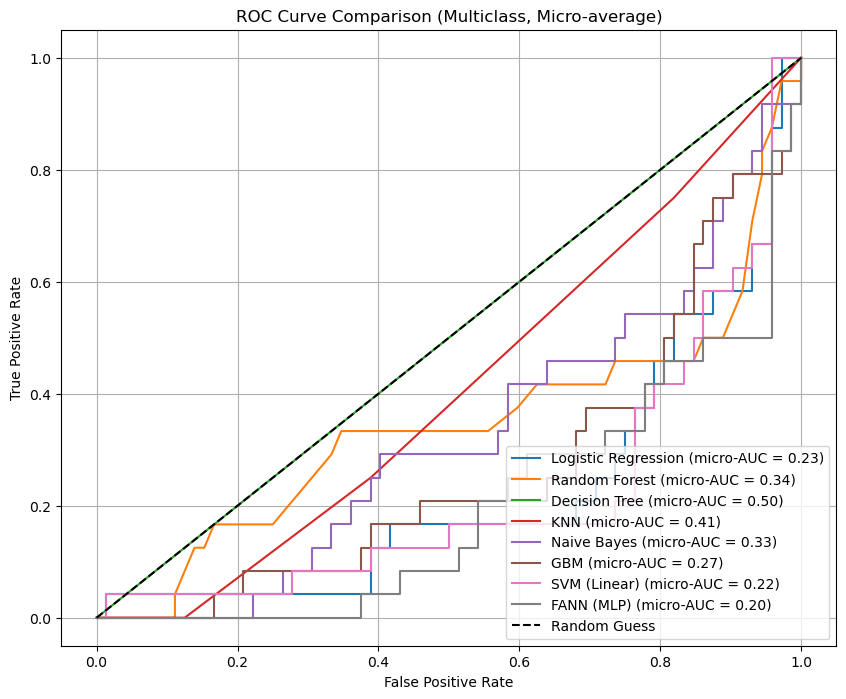

In [331]:
# Determining which model to use (multiclass ROC: micro-average)

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', 
        max_iter=5000,
        solver='lbfgs'
    ),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "GBM": GradientBoostingClassifier(random_state=5),
    "SVM (Linear)": LinearSVC(
        class_weight='balanced', 
        random_state=5, 
        max_iter=10000,          # Increased for convergence
        dual=False               # Set to False because n_samples > n_features
    ),
    "FANN (MLP)": MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=300,
        early_stopping=True,
        random_state=5,
    ),
}

def get_score_matrix(fitted_model, X):
    # Prefer probabilities when available; fall back to decision_function (e.g., LinearSVC)
    if hasattr(fitted_model, "predict_proba"):
        scores = fitted_model.predict_proba(X)
    elif hasattr(fitted_model, "decision_function"):
        scores = fitted_model.decision_function(X)

    scores = np.asarray(scores)
    if scores.ndim == 1:
        # Binary case: convert (n_samples,) -> (n_samples, 1) for consistent ravel() behavior
        scores = scores.reshape(-1, 1)
    return scores

plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_score = get_score_matrix(model, X_test_scaled)  # (n_samples, n_classes) or (n_samples, 1)

    # Binarize y_test using the model's class order to align columns
    y_test_bin = label_binarize(y_test, classes=model.classes_)

    # Micro-average ROC (treat each class prediction as a binary decision)
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (micro-AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Multiclass, Micro-average)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
# Logistic Regression
logistic_model = LogisticRegression(class_weight='balanced')
logistic_model.fit(X_train_scaled, y_train)

y_prediction = logistic_model.predict(X_test_scaled)

log_acc = accuracy_score(y_test, y_prediction)
print('Logistic Regression Accuracy =', log_acc)

Logistic Regression Accuracy = 0.3601694915254237


/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# FANN (MLPClassifier)
fann_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    learning_rate_init=1e-3,
    max_iter=500,
    early_stopping=True,
    random_state=5,
 )
fann_model.fit(X_train_scaled, y_train)

y_pred_fann = fann_model.predict(X_test_scaled)

fann_acc = accuracy_score(y_test, y_pred_fann)
print('FANN (MLP) Accuracy =', fann_acc)

FANN (MLP) Accuracy = 0.3220338983050847


In [ ]:
# SVM (LinearSVC)
svm_model = LinearSVC(class_weight='balanced', random_state=5, dual=False, max_iter=5000)
svm_model.fit(X_train_scaled, y_train)

y_pred_svm = svm_model.predict(X_test_scaled)

svm_acc = accuracy_score(y_test, y_pred_svm)
print('SVM (Linear) Accuracy =', svm_acc)

SVM (Linear) Accuracy = 0.3559322033898305


In [ ]:
# Gradient Boosting (GBM)
gbm_model = GradientBoostingClassifier(random_state=5)
gbm_model.fit(X_train_scaled, y_train)

y_pred_gbm = gbm_model.predict(X_test_scaled)

gbm_acc = accuracy_score(y_test, y_pred_gbm)
print('GBM Accuracy =', gbm_acc)

GBM Accuracy = 0.3432203389830508


In [ ]:
# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

y_pred_nb = nb_model.predict(X_test_scaled)

nb_acc = accuracy_score(y_test, y_pred_nb)
print('Naive Bayes Accuracy =', nb_acc)

Naive Bayes Accuracy = 0.3644067796610169


In [ ]:
# KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)

y_pred_knn = knn_model.predict(X_test_scaled)

knn_acc = accuracy_score(y_test, y_pred_knn)
print('KNN Accuracy =', knn_acc)

KNN Accuracy = 0.25


In [ ]:
# Decision Tree
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=5)
dt_model.fit(X_train_scaled, y_train)

y_pred_dt = dt_model.predict(X_test_scaled)

dt_acc = accuracy_score(y_test, y_pred_dt)
print('Decision Tree Accuracy =', dt_acc)

Decision Tree Accuracy = 0.3050847457627119


In [ ]:
# ExtraTrees (tuned from honest GroupSplit search if available)
from sklearn.ensemble import ExtraTreesClassifier

if 'X_train_scaled' not in globals() or 'X_test_scaled' not in globals():
    raise NameError('Run the scaling cell first (need X_train_scaled/X_test_scaled).')
if 'y_train' not in globals() or 'y_test' not in globals():
    raise NameError('Run the train/test split cell first (need y_train/y_test).')

# If you ran the auto-tune cell, reuse its best params; otherwise fall back to a strong default.
best_params = None
if 'honest_results' in globals() and isinstance(honest_results, dict) and 'ExtraTrees' in honest_results:
    best_params = honest_results['ExtraTrees'].get('best_params')
    print('Using tuned ExtraTrees params from auto-tune.')
else:
    print('Using default ExtraTrees params (auto-tune not found).')

et_kwargs = dict(
    n_estimators=1500,
    random_state=5,
    n_jobs=-1,
    class_weight='balanced',
    bootstrap=False,
 )
if isinstance(best_params, dict):
    # Filter only params that belong to ExtraTreesClassifier itself
    for k, v in best_params.items():
        if k.startswith('clf__'):
            # In case params came from a Pipeline (they shouldn't for ExtraTrees), strip prefix.
            et_kwargs[k.replace('clf__', '')] = v
        else:
            et_kwargs[k] = v

extra_trees_model = ExtraTreesClassifier(**et_kwargs)
extra_trees_model.fit(X_train_scaled, y_train)
y_pred_et = extra_trees_model.predict(X_test_scaled)
et_acc = accuracy_score(y_test, y_pred_et)
print('ExtraTrees Accuracy =', et_acc)

Using tuned ExtraTrees params from auto-tune.
ExtraTrees Accuracy = 0.3813559322033898


In [ ]:
# Neural Network (Dense) on bandpower features
num_classes = int(np.unique(np.asarray(y_train)).size)
y_train_np = np.asarray(y_train, dtype=np.int32)
y_test_np = np.asarray(y_test, dtype=np.int32)

# One-hot encode targets for categorical_crossentropy
y_train_cat = tf.keras.utils.to_categorical(y_train_np, num_classes=num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test_np, num_classes=num_classes)

input_shape = X_train_scaled.shape[1]
model = Sequential([
    Input(shape=(input_shape,)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train_cat, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
loss, nn_acc = model.evaluate(X_test_scaled, y_test_cat, verbose=0)
print(f"Dense NN Accuracy = {nn_acc:.4f}")

y_pred_probs = model.predict(X_test_scaled, verbose=0)
nn_pred = tf.argmax(y_pred_probs, axis=1).numpy()

Dense NN Accuracy = 0.3475


# 7. Deep learning models (raw windows)

Sequence/conv models trained on raw window tensors with per-channel normalization (fit on train only).

In [ ]:
# Deep Learning setup (sequence models)
# Correct shape: (n_windows, timesteps, n_channels=4)
if 'X_train_seq' not in globals() or 'X_test_seq' not in globals():
    raise NameError('Run the train/test split cell first (it defines X_train_seq/X_test_seq when using windowing).')

X_train_seq = np.asarray(X_train_seq, dtype=np.float32)
X_test_seq = np.asarray(X_test_seq, dtype=np.float32)
timesteps = int(X_train_seq.shape[1])
n_channels = int(X_train_seq.shape[2])
print('Sequence tensor shape:', X_train_seq.shape, '(timesteps=', timesteps, ', channels=', n_channels, ')')

# Normalize per-channel using training statistics (prevents leakage)
seq_mean = X_train_seq.mean(axis=(0, 1), keepdims=True)
seq_std = X_train_seq.std(axis=(0, 1), keepdims=True) + 1e-6
X_train_seq = (X_train_seq - seq_mean) / seq_std
X_test_seq = (X_test_seq - seq_mean) / seq_std

y_train_np = np.asarray(y_train, dtype=np.int32)
y_test_np = np.asarray(y_test, dtype=np.int32)
num_classes = int(np.unique(y_train_np).size)
print('num_classes =', num_classes)

# Class weights to mitigate imbalance
class_weights = None
try:
    classes = np.arange(num_classes, dtype=np.int32)
    cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_np)
    class_weights = {int(c): float(w) for c, w in zip(classes, cw)}
    print('class_weights:', class_weights)
except Exception as e:
    print('Could not compute class weights:', e)

early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)

def train_eval_keras(model, name: str, epochs: int = 30, batch_size: int = 64):
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss=SparseCategoricalCrossentropy(),
        metrics=['accuracy'],
    )
    model.fit(
        X_train_seq, y_train_np,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        callbacks=[early_stop],
        class_weight=class_weights,
        verbose=0,
    )
    loss, acc = model.evaluate(X_test_seq, y_test_np, verbose=0)
    print(f"{name} Accuracy = {acc:.4f}")
    return acc

Sequence tensor shape: (504, 64, 4) (timesteps= 64 , channels= 4 )
num_classes = 4
class_weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


In [ ]:
# DeepConvNet (lightweight) on windowed sequences
if 'X_train_seq' not in globals() or 'X_test_seq' not in globals():
    raise NameError("Run the deep-learning setup cell first (need X_train_seq/X_test_seq).")
if 'y_train_np' not in globals() or 'y_test_np' not in globals():
    raise NameError("Run the deep-learning setup cell first (need y_train_np/y_test_np).")

# Convert to 2D conv format: (batch, channels, samples, 1)
X_train_eeg = np.transpose(X_train_seq, (0, 2, 1))[:, :, :, None]
X_test_eeg = np.transpose(X_test_seq, (0, 2, 1))[:, :, :, None]

n_channels = int(X_train_eeg.shape[1])
timesteps = int(X_train_eeg.shape[2])
num_classes = int(np.unique(y_train_np).size)

early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)

kernel_w = max(5, min(15, timesteps))
pool_w = 2 if timesteps >= 2 else 1

deepconvnet_model = Sequential([
    Input(shape=(n_channels, timesteps, 1)),
    Conv2D(25, (1, kernel_w), padding='same', use_bias=True),
    BatchNormalization(),
    Activation('elu'),
    # Mix information across channels
    Conv2D(25, (n_channels, 1), padding='valid', use_bias=True),
    BatchNormalization(),
    Activation('elu'),
    AveragePooling2D((1, pool_w)),
    Dropout(0.5),

    Conv2D(50, (1, kernel_w), padding='same', use_bias=True),
    BatchNormalization(),
    Activation('elu'),
    AveragePooling2D((1, pool_w)),
    Dropout(0.5),

    Flatten(),
    Dense(num_classes, activation='softmax'),
])

deepconvnet_model.compile(optimizer=Adam(1e-3), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
deepconvnet_model.fit(
    X_train_eeg, y_train_np,
    epochs=30, batch_size=64, validation_split=0.1, callbacks=[early_stop], verbose=0,
    class_weight=class_weights if 'class_weights' in globals() else None,
 )
_, deepconvnet_acc = deepconvnet_model.evaluate(X_test_eeg, y_test_np, verbose=0)
print(f"DeepConvNet Accuracy = {deepconvnet_acc:.4f}")

DeepConvNet Accuracy = 0.2924


In [ ]:
# EEGNet on windowed sequences (n_windows, timesteps, n_channels)
if 'X_train_seq' not in globals() or 'X_test_seq' not in globals():
    raise NameError("Run the deep-learning setup cell first (need X_train_seq/X_test_seq).")
if 'y_train_np' not in globals() or 'y_test_np' not in globals():
    raise NameError("Run the deep-learning setup cell first (need y_train_np/y_test_np).")

# Convert to 2D conv format: (batch, channels, samples, 1) where channels=4, samples=timesteps
X_train_eeg = np.transpose(X_train_seq, (0, 2, 1))[:, :, :, None]
X_test_eeg = np.transpose(X_test_seq, (0, 2, 1))[:, :, :, None]

n_channels = int(X_train_eeg.shape[1])
timesteps = int(X_train_eeg.shape[2])
num_classes = int(np.unique(y_train_np).size)

early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)

kern_len = max(8, min(64, timesteps))
F1 = 8
D = 2
F2 = F1 * D

inp = Input(shape=(n_channels, timesteps, 1))
x = Conv2D(F1, (1, kern_len), padding='same', use_bias=False)(inp)
x = BatchNormalization()(x)

# Spatial filtering across channels
x = DepthwiseConv2D((n_channels, 1), depth_multiplier=D, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = AveragePooling2D((1, max(1, timesteps // 8)))(x)
x = Dropout(0.25)(x)

x = SeparableConv2D(F2, (1, max(3, kern_len // 2)), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = AveragePooling2D((1, max(1, timesteps // 8)))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
out = Dense(num_classes, activation='softmax')(x)
eegnet_model = tf.keras.Model(inputs=inp, outputs=out)

eegnet_model.compile(optimizer=Adam(1e-3), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
eegnet_model.fit(
    X_train_eeg, y_train_np,
    epochs=30, batch_size=64, validation_split=0.1, callbacks=[early_stop], verbose=0,
    class_weight=class_weights if 'class_weights' in globals() else None,
 )
_, eegnet_acc = eegnet_model.evaluate(X_test_eeg, y_test_np, verbose=0)
print(f"EEGNet Accuracy = {eegnet_acc:.4f}")

EEGNet Accuracy = 0.2627


In [ ]:
# "Mambular"-inspired gated causal Conv1D stack (Keras 3 compatible)

class GLU(Layer):
    def call(self, inputs):
        a, b = tf.split(inputs, num_or_size_splits=2, axis=-1)
        return a * tf.sigmoid(b)

def mambular_block(x, d_model: int, kernel_size: int = 7, dropout: float = 0.2):
    h = Conv1D(filters=2 * d_model, kernel_size=kernel_size, padding='causal')(x)
    h = GLU()(h)
    h = Dropout(dropout)(h)
    h = Dense(d_model)(h)
    return Add()([x, h])

d_model_m = 64
inp = Input(shape=(timesteps, n_channels))
x = Dense(d_model_m)(inp)
x = LayerNormalization()(x)
x = mambular_block(x, d_model_m, kernel_size=min(7, timesteps))
x = LayerNormalization()(x)
x = mambular_block(x, d_model_m, kernel_size=min(15, timesteps))
x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
out = Dense(num_classes, activation='softmax')(x)
mambular_model = Model(inp, out)

mambular_acc = train_eval_keras(mambular_model, 'Mambular')

Mambular Accuracy = 0.2924


In [ ]:
# Transformer encoder over time (timesteps) with channel features
d_model = 64
num_heads = 4
ff_dim = 128

inp = Input(shape=(timesteps, n_channels))
x = Dense(d_model)(inp)

pos = tf.range(start=0, limit=timesteps, delta=1)
pos_emb = tf.keras.layers.Embedding(input_dim=timesteps, output_dim=d_model)(pos)
x = x + pos_emb
x = LayerNormalization()(x)

attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
x = Add()([x, attn_out])
x = LayerNormalization()(x)

ffn = Dense(ff_dim, activation='relu')(x)
ffn = Dropout(0.2)(ffn)
ffn = Dense(d_model)(ffn)
x = Add()([x, ffn])
x = LayerNormalization()(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)
out = Dense(num_classes, activation='softmax')(x)
transformer_model = tf.keras.Model(inputs=inp, outputs=out)
transformer_acc = train_eval_keras(transformer_model, 'Transformer')

Transformer Accuracy = 0.3220


In [ ]:
# LSTM (correct: timesteps=time, features=channels)
lstm_model = Sequential([
    Input(shape=(timesteps, n_channels)),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax'),
])
lstm_acc = train_eval_keras(lstm_model, 'LSTM')

LSTM Accuracy = 0.2839


In [ ]:
# RNN (SimpleRNN) — correct: timesteps=time, features=channels
rnn_model = Sequential([
    Input(shape=(timesteps, n_channels)),
    SimpleRNN(64, activation='tanh'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax'),
])
rnn_acc = train_eval_keras(rnn_model, 'RNN')

RNN Accuracy = 0.3093


In [ ]:
# Hybrid model: CNN + BiLSTM with Self-Attention
if 'X_train_seq' not in globals() or 'y_train_np' not in globals():
    raise NameError("Run the deep-learning setup cell first (it defines X_train_seq/X_test_seq and y_train_np/y_test_np).")

k1 = min(7, int(timesteps))
k2 = min(5, int(timesteps))
stride2 = 2 if int(timesteps) >= 2 else 1

inp = Input(shape=(int(timesteps), int(n_channels)))
x = Conv1D(64, kernel_size=k1, padding='same', activation='relu')(inp)
x = Dropout(0.2)(x)
x = Conv1D(64, kernel_size=k2, padding='same', activation='relu', strides=stride2)(x)
x = Dropout(0.2)(x)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.3)(x)

attn = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
x = Add()([x, attn])
x = LayerNormalization()(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)
out = Dense(int(num_classes), activation='softmax')(x)

cnn_bilstm_attn_model = tf.keras.Model(inputs=inp, outputs=out)
cnn_bilstm_attn_acc = train_eval_keras(cnn_bilstm_attn_model, 'CNN-BiLSTM + Attention')

CNN-BiLSTM + Attention Accuracy = 0.2881


# 8. Results summary

In [ ]:
# Print accuracies (only for models that were run)

print('Classic Model Accuracies: \n')

print('Logistic Regression Accuracy    -', log_acc)
print('ExtraTrees Accuracy             -', et_acc)
print('Decision Tree Accuracy          -', dt_acc)
print('KNN Accuracy                    -', knn_acc)
print('Naive Bayes Accuracy            -', nb_acc)
print('GBM Accuracy                    -', gbm_acc)
print('SVM (Linear) Accuracy           -', svm_acc)
print('FANN (MLP) Accuracy             -', fann_acc)
print('Neural Network (Dense) Accuracy -', nn_acc)

# Deep learning models (sequence models)

print('\nDeep Learning Models Accuracies: \n')

print('RNN Accuracy                    -', rnn_acc)
print('LSTM Accuracy                   -', lstm_acc)
print('Transformer Accuracy            -', transformer_acc)
print('Mambular Accuracy               -', mambular_acc)
print('EEGNet Accuracy                 -', eegnet_acc)
print('DeepConvNet Accuracy            -', deepconvnet_acc)
print('CNN-BiLSTM + Attention Accuracy -', cnn_bilstm_attn_acc)

Classic Model Accuracies: 

Logistic Regression Accuracy    - 0.3601694915254237
ExtraTrees Accuracy             - 0.3813559322033898
Decision Tree Accuracy          - 0.3050847457627119
KNN Accuracy                    - 0.25
Naive Bayes Accuracy            - 0.3644067796610169
GBM Accuracy                    - 0.3432203389830508
SVM (Linear) Accuracy           - 0.3559322033898305
FANN (MLP) Accuracy             - 0.3220338983050847
Neural Network (Dense) Accuracy - 0.347457617521286

Deep Learning Models Accuracies: 

RNN Accuracy                    - 0.3093220293521881
LSTM Accuracy                   - 0.2838982939720154
Transformer Accuracy            - 0.32203391194343567
Mambular Accuracy               - 0.2923728823661804
EEGNet Accuracy                 - 0.26271185278892517
DeepConvNet Accuracy            - 0.2923728823661804
CNN-BiLSTM + Attention Accuracy - 0.2881355881690979


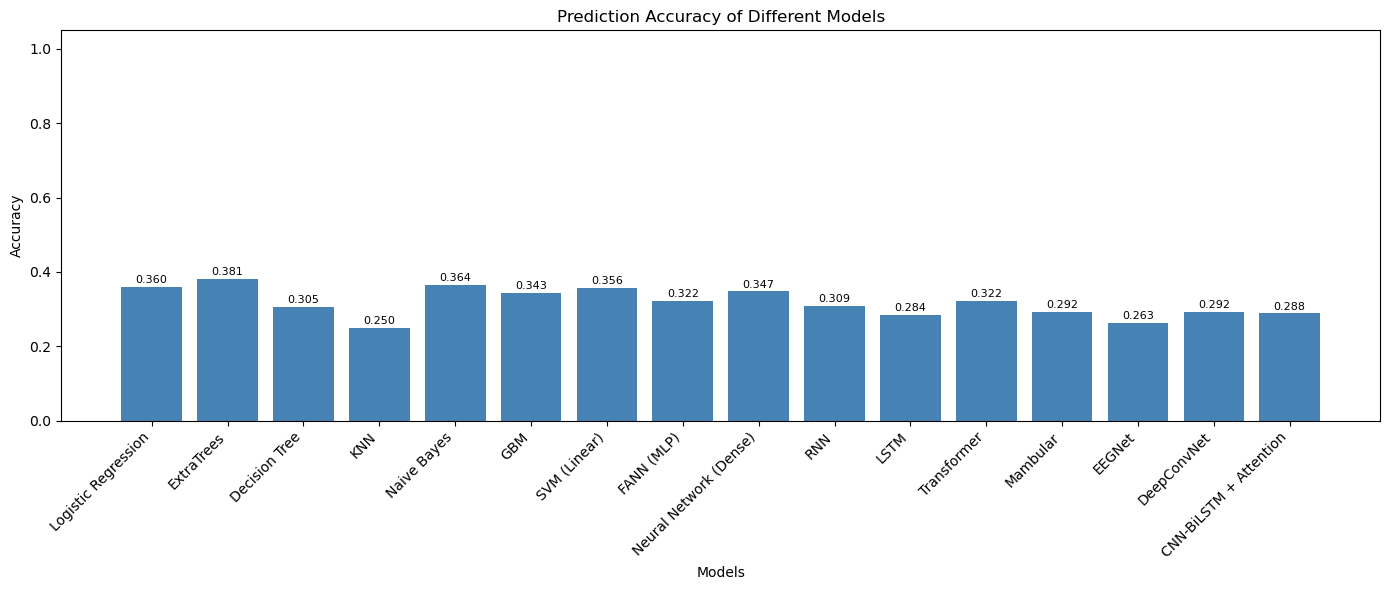

In [ ]:
# Accuracy comparison across models (only include ones that exist)
model_acc = {}
for name, var in [
    ('Logistic Regression', 'log_acc'),
    ('ExtraTrees', 'et_acc'),
    ('Decision Tree', 'dt_acc'),
    ('KNN', 'knn_acc'),
    ('Naive Bayes', 'nb_acc'),
    ('GBM', 'gbm_acc'),
    ('SVM (Linear)', 'svm_acc'),
    ('FANN (MLP)', 'fann_acc'),
    ('Neural Network (Dense)', 'nn_acc'),
    ('RNN', 'rnn_acc'),
    ('LSTM', 'lstm_acc'),
    ('Transformer', 'transformer_acc'),
    ('Mambular', 'mambular_acc'),
    ('EEGNet', 'eegnet_acc'),
    ('DeepConvNet', 'deepconvnet_acc'),
    ('CNN-BiLSTM + Attention', 'cnn_bilstm_attn_acc'),
 ]:
    if var in globals():
        model_acc[name] = float(globals()[var])

plt.figure(figsize=(14, 6))
names = list(model_acc.keys())
scores = list(model_acc.values())
bars = plt.bar(names, scores, color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Prediction Accuracy of Different Models')

for b, s in zip(bars, scores):
    plt.text(b.get_x() + b.get_width()/2, s + 0.005, f'{s:.3f}', ha='center', va='bottom', fontsize=8)

plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

In [ ]:
# Interpretation / Evaluation (robust to stale variables)

y_test_arr = np.asarray(y_test)
labels = sorted(pd.Series(y_test_arr).unique())
target_names = [str(l) for l in labels]

def _report(name: str, y_pred):
    if y_pred is None:
        print(f"{name}: not available")
        return
    y_pred = np.asarray(y_pred)
    if len(y_pred) != len(y_test_arr):
        print(f"{name}: skipped (length mismatch y_test={len(y_test_arr)} vs y_pred={len(y_pred)})")
        return
    print(f"{name}:")
    print(classification_report(y_test_arr, y_pred, target_names=target_names, zero_division=0))
    print('------------------------------------------------------\n')

# Logistic Regression
_report('Logistic Regression', globals().get('y_prediction'))

# ExtraTrees
_report('ExtraTrees', globals().get('y_pred_et'))

# Dense NN (recompute predictions if needed)
dense_pred = None
if 'nn_pred' in globals() and len(np.asarray(nn_pred)) == len(y_test_arr):
    dense_pred = nn_pred
else:
    # Try to recompute using the latest Keras dense model if it exists
    if 'model' in globals() and hasattr(model, 'predict') and 'X_test_scaled' in globals():
        try:
            probs = model.predict(X_test_scaled, verbose=0)
            dense_pred = np.argmax(probs, axis=1)
        except Exception as e:
            print('Dense NN: could not recompute predictions:', e)
            dense_pred = None

_report('Neural Network (Dense)', dense_pred)

Logistic Regression:
              precision    recall  f1-score   support

           0       0.34      0.37      0.35        60
           1       0.32      0.28      0.30        60
           2       0.34      0.33      0.34        60
           3       0.43      0.46      0.45        56

    accuracy                           0.36       236
   macro avg       0.36      0.36      0.36       236
weighted avg       0.36      0.36      0.36       236

------------------------------------------------------

ExtraTrees:
              precision    recall  f1-score   support

           0       0.44      0.35      0.39        60
           1       0.44      0.38      0.41        60
           2       0.28      0.30      0.29        60
           3       0.39      0.50      0.44        56

    accuracy                           0.38       236
   macro avg       0.39      0.38      0.38       236
weighted avg       0.39      0.38      0.38       236

-----------------------------------------